# Holstein (semi-classical)

## Initialize variables and imports

In [1]:
import numpy
from scipy import linalg, special, integrate, optimize
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot
import pandas
import gc
import os

from tqdm.notebook import tqdm

import joblib

import bmme

In [26]:
omega = .3
lamda = .15                            # .03, .15, .3, .6 eV
epsilon = .15  
Gamma = .05                            # .01, .026, .05 eV
T = .026

fix_epsilon = True
if fix_epsilon:
    epsilon_fixed = epsilon
    epsilon += lamda**2 / omega
    
def file_apx():
    return f"{'ef' if fix_epsilon else 'e'}{(epsilon_fixed if fix_epsilon else epsilon):.3f}_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}"

#print(file_apx(), epsilon)

## Calculate Langevin quantities

In [15]:
voltages = numpy.arange(0, 2001, 50)
x1 = numpy.linspace(-100, 100, 2001)

d_ops, d_dags = bmme.generate_fermionic_ops(1)
d1_op, d1_dag = d_ops[0], d_dags[0]

Gammas = numpy.array([[[Gamma, Gamma]]])

def func_H_S(x):
    H_S = .5 * (omega * x[0]**2) * numpy.identity(d1_op.shape[0])
    H_S += epsilon * d1_dag @ d1_op
    H_S += numpy.sqrt(2) * lamda * x[0] * d1_dag @ d1_op
    return H_S

def func_ddx_H_S(k, x):
    if k == 0:
        ddx = omega * x[0] * numpy.identity(d1_op.shape[0])
        ddx += numpy.sqrt(2) * lamda * d1_dag @ d1_op
        return ddx

def my_func(i, x):
    return bmme.calc_langevin_quantities_symmetric_potential(func_H_S, func_ddx_H_S, x, d_ops, None, Gammas,
                                                            voltages*1e-3, T, T, method="analytic")

mean_force = numpy.zeros((len(voltages), len(x1)), dtype=numpy.float64)
friction = numpy.zeros((len(voltages), len(x1)), dtype=numpy.float64)
correlation = numpy.zeros((len(voltages), len(x1)), dtype=numpy.float64)
current_L = numpy.zeros((len(voltages), len(x1)), dtype=numpy.float64)
current_R = numpy.zeros((len(voltages), len(x1)), dtype=numpy.float64)

#mean_force[:51] = numpy.load("data/holstein_semicl/mean_force_voltages.npy")
#friction[:51] = numpy.load("data/holstein_semicl/friction_voltages.npy")
#correlation[:51] = numpy.load("data/holstein_semicl/correlation_voltages.npy")
#currents[:51] = numpy.load("data/holstein_semicl/currents_voltages.npy")

results = joblib.Parallel(n_jobs=10)(joblib.delayed(my_func)(i, [x]) for i, x in enumerate(tqdm(x1)))

for i in range(len(results)):
    mean_force[:,i] = results[i][0][:,0]
    friction[:,i] = results[i][1][:,0,0]
    correlation[:,i] = results[i][2][:,0,0]
    current_L[:,i] = results[i][3][:,0]
    current_R[:,i] = results[i][3][:,1]

mean_force = mean_force.flatten()
friction = friction.flatten()
correlation = correlation.flatten()
current_L = current_L.flatten()
current_R = current_R.flatten()

voltages_new = numpy.array(numpy.repeat(voltages, len(x1)), dtype=numpy.int32)
x1_new = numpy.tile(x1, len(voltages))

panda = pandas.DataFrame(data={"voltage": voltages_new,
                               "X": x1_new,
                               "current_L": current_L,
                               "current_R": current_R,
                               "mean_force": mean_force,
                               "friction": friction,
                               "diffusion": correlation})

print(panda.dtypes)

panda.to_csv(f"data/holstein_semicl/langevin_bmme_{file_apx()}.csv")

#numpy.save(f"data/holstein_semicl/mean_force_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}.npy", mean_force)
#numpy.save(f"data/holstein_semicl/friction_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}.npy", friction)
#numpy.save(f"data/holstein_semicl/correlation_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}.npy", correlation)
#numpy.save(f"data/holstein_semicl/currents_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}.npy", currents)

  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\priva\AppData\Local\Temp\ipykernel_6328\467470538.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_force[:,i] = results[i][0][:,0]
C:\Users\priva\AppData\Local\Temp\ipykernel_6328\467470538.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  friction[:,i] = results[i][1][:,0,0]
C:\Users\priva\AppData\Local\Temp\ipykernel_6328\467470538.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  correlation[:,i] = results[i][2][:,0,0]
C:\Users\priva\AppData\Local\Temp\ipykernel_6328\467470538.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  current_L[:,i] = results[i][3][:,0]
C:\Users\priva\AppData\Local\Temp\ipykernel_6328\467470538.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  current_R[:,i] = results[i][3][:,1]


voltage         int32
X             float64
current_L     float64
current_R     float64
mean_force    float64
friction      float64
diffusion     float64
dtype: object


## Render and plot trajectories (not migrated)

  0%|          | 0/1000000 [00:00<?, ?it/s]

(2, 1000001, 100)


  0%|          | 0/100 [00:00<?, ?it/s]

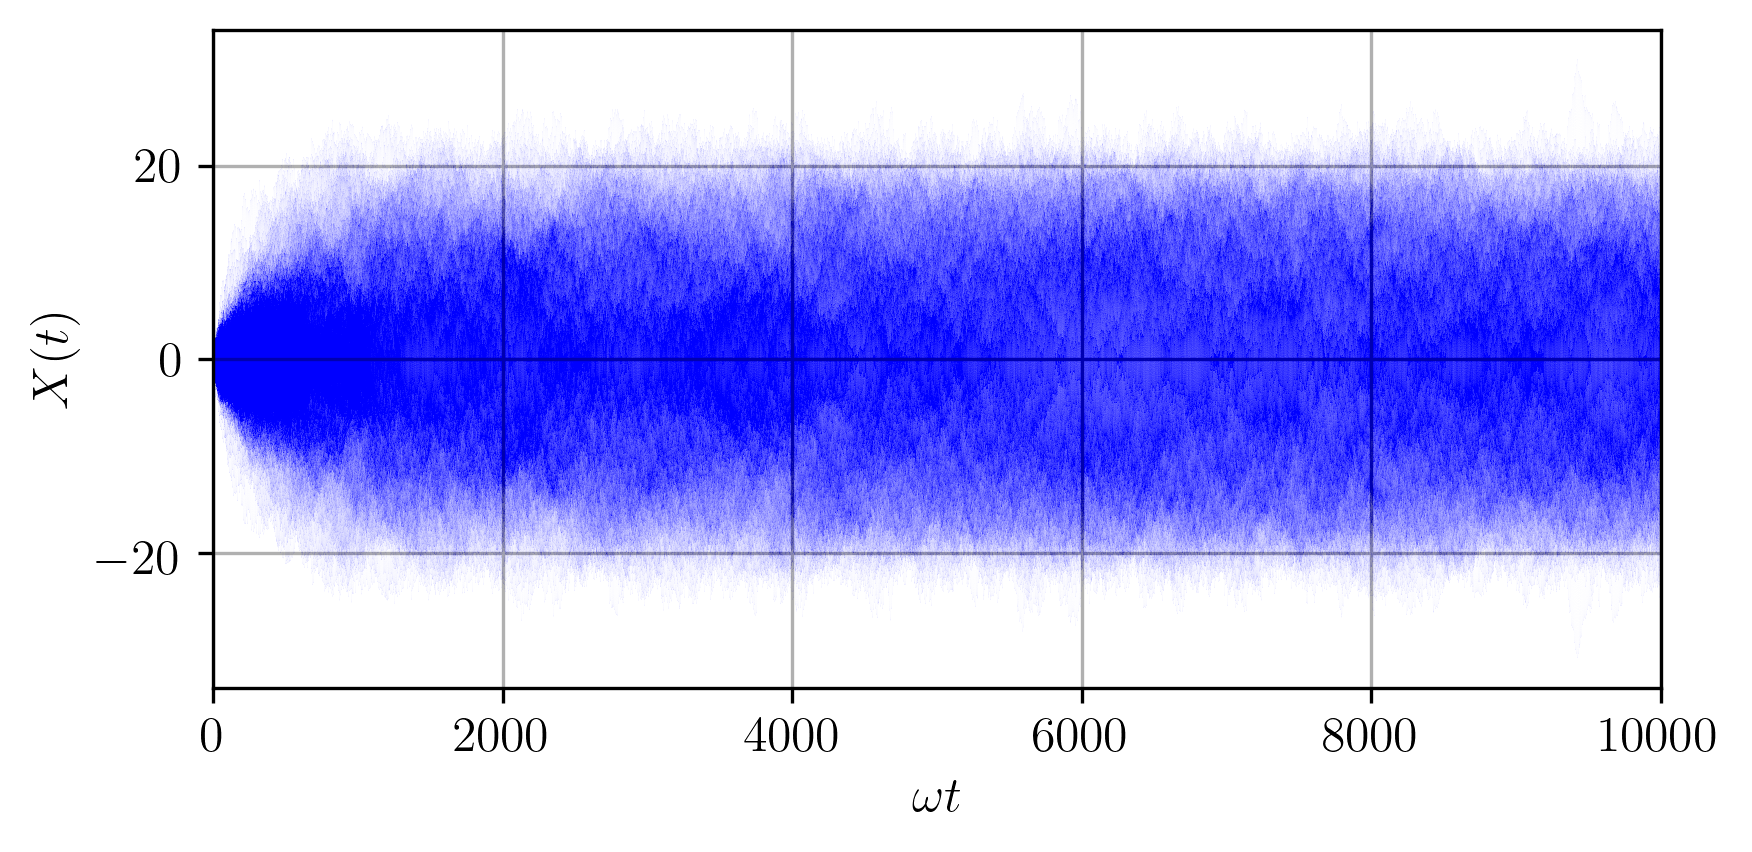

5743

In [10]:
vindex = 90

x_init = 0.0 #-epsilon / (numpy.sqrt(2) * lamda)
p_init = 0.0

def render_trajectories(local_vindex, N_traj, save=False):
    
    grid = x1
    mbaoab_F = mean_force[local_vindex] / omega
    mbaoab_gamma = friction[local_vindex]
    mbaoab_sigma = numpy.sqrt(2 * correlation[local_vindex] / omega) #linalg.sqrtm(2 * corr)

    def to_int_w_numpy_support(stuff):
        if isinstance(stuff, numpy.ndarray):
            return numpy.array(stuff, dtype=int)
        else:
            return int(stuff)

    def get_lin_int(x, X):
        index_low = grid[0]
        index_high = grid[-1]
        index_l = to_int_w_numpy_support((x - index_low) * len(grid) / (index_high - index_low))
        index_h = index_l + 1
        x_1 = grid[index_l]
        x_2 = grid[index_h]

        x_target = x

        return (X[index_l] * (x_2 - x_target) + X[index_h] * (x_target - x_1)) / (x_2 - x_1)

    def solve_mbaoab(x_0, v_0, N, dt=1e-2, K=10):
        n = len(x_0)
        factor = numpy.sqrt(dt / K)
        x = numpy.zeros((N+1, n))
        v = numpy.zeros((N+1, n))
        x[0] = x_0
        v[0] = v_0
        for i in tqdm(range(N)):
            x[i+1] = x[i] + 0.5 * dt * v[i]
            F = get_lin_int(x[i+1], mbaoab_F)
            gam = get_lin_int(x[i+1], mbaoab_gamma)
            sigma = get_lin_int(x[i+1], mbaoab_sigma)
            v[i+1] = v[i] + 0.5 * dt * F
            G = numpy.exp(-dt * gam / (2 * K))
            for j in range(K):
                v[i+1] = G * G * v[i+1] + factor * G * sigma * numpy.random.randn(n)
            v[i+1] += 0.5 * dt * F
            x[i+1] += 0.5 * dt * v[i+1]
        return x, v
    
    x_0 = numpy.array([x_init] * N_traj, dtype=numpy.float64)
    v_0 = numpy.array([p_init] * N_traj, dtype=numpy.float64)
    
    x, v = solve_mbaoab(x_0, v_0, 1000000)
    return x, v
    
results = joblib.Parallel(n_jobs=1)(joblib.delayed(render_trajectories)(local_vindex, 100) for local_vindex in [vindex])

trajectories = numpy.array(results[0])
print(trajectories.shape)

fig = pyplot.figure(figsize=(6,3), tight_layout=True)
ax1 = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(2, 1, 2)

wt = numpy.arange(trajectories.shape[1])*1e-2

for i in tqdm(range(trajectories.shape[2])):
    x_sol = trajectories[0,:,i]
    v_sol = trajectories[1,:,i]
    ax1.plot(wt, x_sol, ",b", alpha=0.005)
    
ax1.set_xlabel("$\\omega t$")
ax1.set_ylabel("$X(t)$")
ax1.set_xlim(0, 10000)
#ax1.set_ylim(-20, 10)
ax1.grid()

pyplot.gcf().set_dpi(300)
#pyplot.savefig("SL_1cl_trajectories_x=-9.png")
pyplot.show()

del trajectories, results
fig.clf()
gc.collect()

## Calculate classical averages

In [27]:
method = "bmme"

panda = pandas.read_csv(f"data/holstein_semicl/langevin_{method}_{file_apx()}.csv")

voltages = numpy.unique(panda["voltage"].to_numpy())

x_init = 0.0 #-epsilon / (numpy.sqrt(2) * lamda)
p_init = 0.0

def calculate_mean_values(voltage, N_traj):
    #from tqdm import tqdm as cmd_tqdm

    local_panda = panda[panda["voltage"] == voltage]

    grid = local_panda["X"].to_numpy()
    mbaoab_F = local_panda["mean_force"].to_numpy() / omega
    mbaoab_gamma = local_panda["friction"].to_numpy()
    mbaoab_sigma = numpy.sqrt(2 * local_panda["diffusion"].to_numpy() / omega) #linalg.sqrtm(2 * corr)
    current_L = local_panda["current_L"].to_numpy()
    if method == "bmme":
        current_R = local_panda["current_R"].to_numpy()

    def to_int_w_numpy_support(stuff):
        if isinstance(stuff, numpy.ndarray):
            return numpy.array(stuff, dtype=int)
        else:
            return int(stuff)

    def get_lin_int(x, X):
        index_low = grid[0]
        index_high = grid[-1]
        index_l = to_int_w_numpy_support((x - index_low) * len(grid) / (index_high - index_low))
        index_h = index_l + 1
        x_1 = grid[index_l]
        x_2 = grid[index_h]

        x_target = x

        return (X[index_l] * (x_2 - x_target) + X[index_h] * (x_target - x_1)) / (x_2 - x_1)

    def solve_mbaoab(x_0, v_0, N, dt=1e-2, K=10):
        n = len(x_0)
        factor = numpy.sqrt(dt / K)
        x = numpy.zeros((N+1, n))
        v = numpy.zeros((N+1, n))
        x[0] = x_0
        v[0] = v_0
        for i in range(N):
            x[i+1] = x[i] + 0.5 * dt * v[i]
            F = get_lin_int(x[i+1], mbaoab_F)
            gam = get_lin_int(x[i+1], mbaoab_gamma)
            sigma = get_lin_int(x[i+1], mbaoab_sigma)
            v[i+1] = v[i] + 0.5 * dt * F
            G = numpy.exp(-dt * gam / (2 * K))
            for j in range(K):
                v[i+1] = G * G * v[i+1] + factor * G * sigma * numpy.random.randn(n)
            v[i+1] += 0.5 * dt * F
            x[i+1] += 0.5 * dt * v[i+1]
        return x, v

    def solve_mbaoab_2(x_0, v_0, N, dt=1e-2, K=10):
        n = len(x_0)
        factor = numpy.sqrt(dt / K)
        x = x_0
        v = v_0
        for i in range(N):
            x += 0.5 * dt * v
            F = get_lin_int(x, mbaoab_F)
            gam = get_lin_int(x, mbaoab_gamma)
            sigma = get_lin_int(x, mbaoab_sigma)
            v += 0.5 * dt * F
            G = numpy.exp(-dt * gam / (2 * K))
            for j in range(K):
                v = G * G * v + factor * G * sigma * numpy.random.randn(n)
            v += 0.5 * dt * F
            x += 0.5 * dt * v
        return x, v

    xs = []
    vs = []

    x = numpy.array([x_init] * N_traj, dtype=numpy.float64)
    v = numpy.array([p_init] * N_traj, dtype=numpy.float64)

    for steps in ([500000] + [10000] * 99):
        x, v = solve_mbaoab_2(x, v, steps)
        xs.append(numpy.copy(x))
        vs.append(numpy.copy(v))

    xs = numpy.array(xs).flatten()
    vs = numpy.array(vs).flatten()

    N_val = len(xs)
    print(N_val)

    raw = get_lin_int(xs, current_L)
    avg_J_L = numpy.sum(raw) / N_val
    u_J_L = numpy.sqrt(numpy.sum((raw - avg_J_L)**2)) / N_val

    if method == "bmme":
        raw = get_lin_int(xs, current_R)
        avg_J_R = numpy.sum(raw) / N_val
        u_J_R = numpy.sqrt(numpy.sum((raw - avg_J_R)**2)) / N_val

    avg_X = numpy.sum(xs) / N_val
    u_X = numpy.sqrt(numpy.sum((xs - avg_X)**2)) / N_val

    raw = xs**2
    avg_X2 = numpy.sum(raw) / N_val
    u_X2 = numpy.sqrt(numpy.sum((raw - avg_X2)**2)) / N_val

    avg_P = numpy.sum(vs) / N_val
    u_P = numpy.sqrt(numpy.sum((vs - avg_P)**2)) / N_val

    raw = vs**2
    avg_P2 = numpy.sum(raw) / N_val
    u_P2 = numpy.sqrt(numpy.sum((raw - avg_P2)**2)) / N_val

    del xs, vs
    gc.collect()

    if method == "bmme":
        return numpy.array([[avg_J_L, avg_J_R, avg_X, avg_X2, avg_P, avg_P2],
                       [u_J_L, u_J_R, u_X, u_X2, u_P, u_P2]])
    else:
        return numpy.array([[avg_J_L, avg_X, avg_X2, avg_P, avg_P2],
                       [u_J_L, u_X, u_X2, u_P, u_P2]])


results = joblib.Parallel(n_jobs=10)(joblib.delayed(calculate_mean_values)(voltage, 500) for voltage in tqdm(voltages))
results = numpy.array(results)

if method == "bmme":
    new_panda = pandas.DataFrame(data={"voltage": voltages,
                                       "current_L": results[:,0,0],
                                       "u_current_L": results[:,1,0],
                                       "current_R": results[:,0,1],
                                       "u_current_R": results[:,1,1],
                                       "X": results[:,0,2],
                                       "u_X": results[:,1,2],
                                       "X^2": results[:,0,3],
                                       "u_X^2": results[:,1,3],
                                       "P": results[:,0,4],
                                       "u_P": results[:,1,4],
                                       "P^2": results[:,0,5],
                                       "u_P^2": results[:,1,5]})
else:
    new_panda = pandas.DataFrame(data={"voltage": voltages,
                                       "current_L": results[:,0,0],
                                       "u_current_L": results[:,1,0],
                                       "X": results[:,0,1],
                                       "u_X": results[:,1,1],
                                       "X^2": results[:,0,2],
                                       "u_X^2": results[:,1,2],
                                       "P": results[:,0,3],
                                       "u_P": results[:,1,3],
                                       "P^2": results[:,0,4],
                                       "u_P^2": results[:,1,4]})

print(new_panda.dtypes)

new_panda.to_csv(f"data/holstein_semicl/classical_{method}_{file_apx()}.csv")

  0%|          | 0/41 [00:00<?, ?it/s]

voltage          int64
current_L      float64
u_current_L    float64
current_R      float64
u_current_R    float64
X              float64
u_X            float64
X^2            float64
u_X^2          float64
P              float64
u_P            float64
P^2            float64
u_P^2          float64
dtype: object


## Calculate quantum averages

In [13]:
panda = pandas.read_csv(f"data/holstein_semicl/langevin_{method}_{file_apx()}.csv")

voltages = numpy.unique(panda["voltage"].to_numpy())

# OPTIONAL: select certain voltages only

N_diag = 150
N = 75

solver = bmme.create_holstein_solver_via_diagonalization(epsilon, omega, lamda, N_diag, Gamma, 0.0, 0.0, T, T, include_digamma=True, chop=2*N)

d_op = numpy.array([[0, 1], [0, 0]])
d_dag = numpy.transpose(d_op)
d_op = numpy.kron(d_op, numpy.identity(N_diag))
d_dag = numpy.kron(d_dag, numpy.identity(N_diag))

a_op = numpy.diag(numpy.sqrt(numpy.arange(1, N_diag)), k=1)
a_dag = numpy.transpose(a_op)
a_op = numpy.kron(numpy.identity(2), a_op)
a_dag = numpy.kron(numpy.identity(2), a_dag)

X_op = (a_dag + a_op) / numpy.sqrt(2)
P_op = 1j * (a_dag - a_op) / numpy.sqrt(2)
X2_op = (a_dag + a_op) @ (a_dag + a_op) * 0.5
P2_op = (a_dag - a_op) @ (a_dag - a_op) * (-0.5)
occup_op = d_dag @ d_op
excit_op = a_dag @ a_op

additionals = []

for i in range(N):
    for j in range(N):
        if i != j:
            additionals.append((i, j))
            
for i in range(N):
    for j in range(N):
        if i != j:
            additionals.append((N+i, N+j))

def my_func(voltage):
    solver.chemical_potential = numpy.array([-.0005*voltage, .0005*voltage])
    solver.construct_liouvillian()
    rho_ss = solver.find_steady_state(ignore_coherences=True, additional_coherences=additionals)
    exp_currents = solver.get_currents(rho_ss)
    orig_rho_ss = solver.retransform(rho_ss)
    exp_X = numpy.trace(orig_rho_ss @ X_op)
    exp_X2 = numpy.trace(orig_rho_ss @ X2_op)
    exp_P = numpy.trace(orig_rho_ss @ P_op)
    exp_P2 = numpy.trace(orig_rho_ss @ P2_op)
    exp_occup = numpy.trace(orig_rho_ss @ occup_op)
    exp_excit = numpy.trace(orig_rho_ss @ excit_op)
    return voltage, rho_ss, (exp_currents[0], exp_currents[1], exp_X, exp_X2, exp_P, exp_P2, exp_occup, exp_excit)

results = joblib.Parallel(n_jobs=1)(joblib.delayed(my_func)(voltage) for voltage in tqdm(voltages))

new = not os.path.isfile(f"data/holstein_semicl/quantum_bmme_{file_apx()}_N{N}~{N_diag}.csv")

if new:
    #rpanda = pandas.DataFrame({"voltage": numpy.empty(0, dtype=numpy.int32), "rho_ss": numpy.empty((0, 2*N, 2*N), dtype=numpy.float64)})
    apanda = pandas.DataFrame({"voltage": numpy.empty(0, dtype=numpy.int32),
                               "current_L": numpy.empty(0, dtype=numpy.float64),
                               "current_R": numpy.empty(0, dtype=numpy.float64),
                               "X": numpy.empty(0, dtype=numpy.float64),
                               "X^2": numpy.empty(0, dtype=numpy.float64),
                               "P": numpy.empty(0, dtype=numpy.float64),
                               "P^2": numpy.empty(0, dtype=numpy.float64),
                               "occupation": numpy.empty(0, dtype=numpy.float64),
                               "excitation": numpy.empty(0, dtype=numpy.float64)})
    
else:
    #rpanda = pandas.read_csv(f"data/holstein_semicl/rho_ss_bmme_{file_apx()}_N{N}~{N_diag}.csv")
    apanda = pandas.read_csv(f"data/holstein_semicl/quantum_bmme_{file_apx()}_N{N}~{N_diag}.csv")

for i in range(len(results)):
    #if (rpanda["voltage"] == results[i][0]).any():
    #    rpanda[rpanda["voltage" == results[i][0]]] = results[i][0], results[i][1]
    #else:
    #    rpanda.append({"voltage": results[i][0], "rho_ss": results[i][1]})
    
    if (apanda["voltage"] == results[i][0]).any():
        apanda[apanda["voltage" == results[i][0]]] = results[i][0], results[i][2][0], results[i][2][1],
                                                         results[i][2][2], results[i][2][3], results[i][2][4],
                                                         results[i][2][5], results[i][2][6], results[i][2][7]
    else:
        apanda.append({"voltage": results[i][0],
                       "current_L": results[i][2][0],
                       "current_R": results[i][2][1],
                       "X": results[i][2][2],
                       "X^2": results[i][2][3],
                       "P": results[i][2][4],
                       "P^2": results[i][2][5],
                       "occupation": results[i][2][6],
                       "excitation": results[i][2][7]})

#rpanda.sort(by=["voltages"])
apanda.sort(by=["voltages"])

#rpanda.to_csv(f"data/holstein_semicl/rho_ss_bmme_{file_apx()}_N{N}~{N_diag}.csv")
apanda.to_csv(f"data/holstein_semicl/quantum_bmme_{file_apx()}_N{N}~{N_diag}.csv")

#if new:
#    local_rhos = numpy.zeros((len(voltages), 2*N, 2*N), dtype=numpy.complex128)
#    local_J_L = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_J_R = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_X = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_X2 = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_P = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_P2 = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_occup = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    local_excit = numpy.ones(len(voltages), dtype=numpy.float64) * numpy.nan
#    print("new")
#else:
#    local_rhos = numpy.load(f"data/holstein_semicl/quantum_ss_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}_N{N}~{N_diag}.npy")
#    other_data = numpy.load(f"data/holstein_semicl/quantum_avgs_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}_N{N}~{N_diag}.npy")
#    local_J_L = other_data[:,0]
#    local_J_R = other_data[:,1]
#    local_X = other_data[:,2]
#    local_X2 = other_data[:,3]
#    local_P = other_data[:,4]
#    local_P2 = other_data[:,5]
#    local_occup = other_data[:,6]
#    local_excit = other_data[:,7]
#    print("not new")

#for i, j in zip(range(index_start, index_end, index_step), range(len(local_voltages))):
#    local_rhos[i] = results[j][0]
#    local_J_L[i] = results[j][1][0]
#    local_J_R[i] = results[j][1][1]
#    local_X[i] = results[j][1][2]
#    local_X2[i] = results[j][1][3]
#    local_P[i] = results[j][1][4]
#    local_P2[i] = results[j][1][5]
#    local_occup[i] = results[j][1][6]
#    local_excit[i] = results[j][1][7]

#numpy.save(f"data/holstein_semicl/quantum_ss_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}_N{N}~{N_diag}.npy", local_rhos)
#numpy.save(f"data/holstein_semicl/quantum_avgs_omega{omega:.3f}_lamda{lamda:.3f}_Gamma{Gamma:.3f}_N{N}~{N_diag}.npy", 
#           numpy.array([local_J_L, local_J_R, local_X, local_X2, local_P, local_P2, local_occup, local_excit]).T)

C:\Program Files\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


  0%|          | 0/101 [00:00<?, ?it/s]

new


C:\Users\priva\AppData\Local\Temp\ipykernel_10016\2975965048.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  local_J_L[i] = results[j][1][0]
C:\Users\priva\AppData\Local\Temp\ipykernel_10016\2975965048.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  local_J_R[i] = results[j][1][1]
C:\Users\priva\AppData\Local\Temp\ipykernel_10016\2975965048.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  local_X[i] = results[j][1][2]
C:\Users\priva\AppData\Local\Temp\ipykernel_10016\2975965048.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  local_X2[i] = results[j][1][3]
C:\Users\priva\AppData\Local\Temp\ipykernel_10016\2975965048.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  local_P[i] = results[j][1][4]
C:\Users\priva\AppData\Local\Temp\ipykernel_10016\2975965048.py:91: ComplexWarning: Casting complex values to real disca

## Quantum tests (not migrated)

(150, 150)


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\priva\AppData\Local\Temp\ipykernel_8776\1265407420.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  currents[i] = results[i][0]
C:\Users\priva\AppData\Local\Temp\ipykernel_8776\1265407420.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  populations[i] = results[i][1]


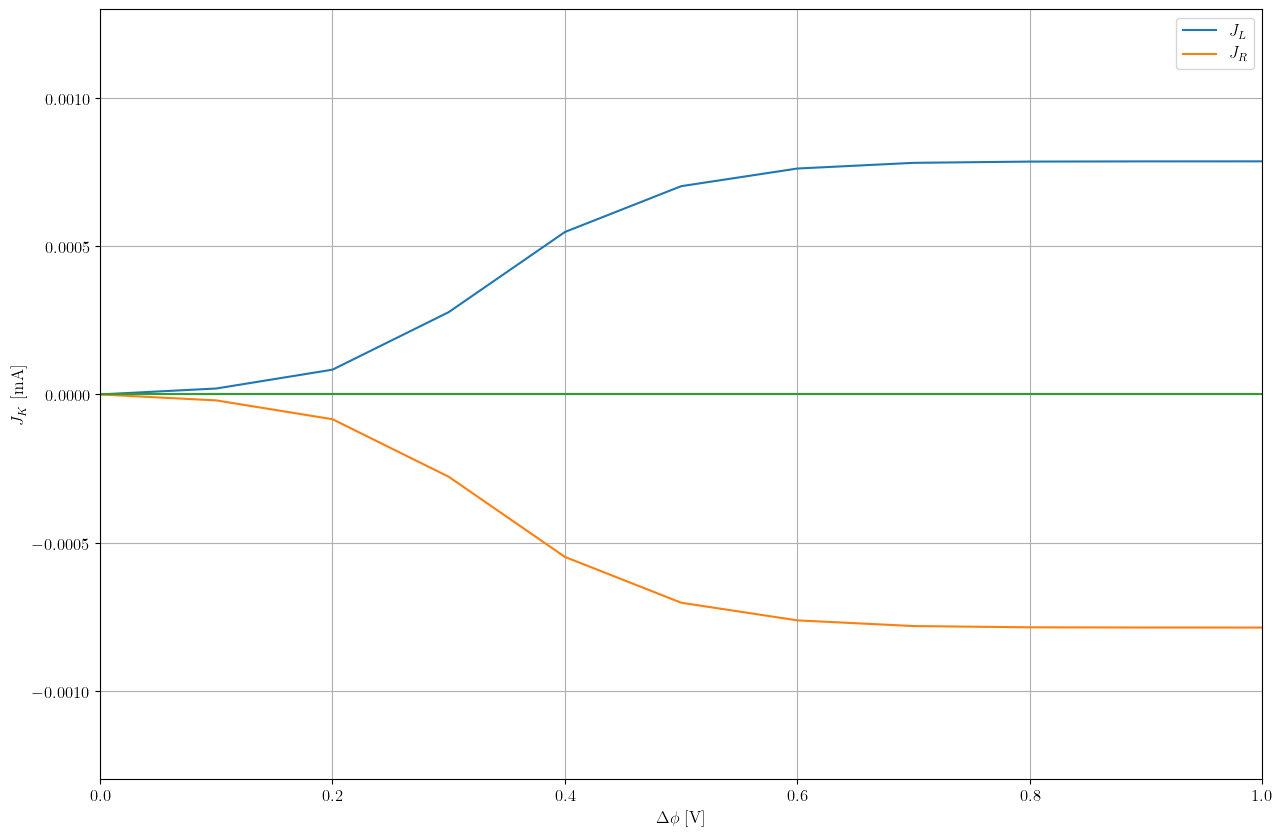

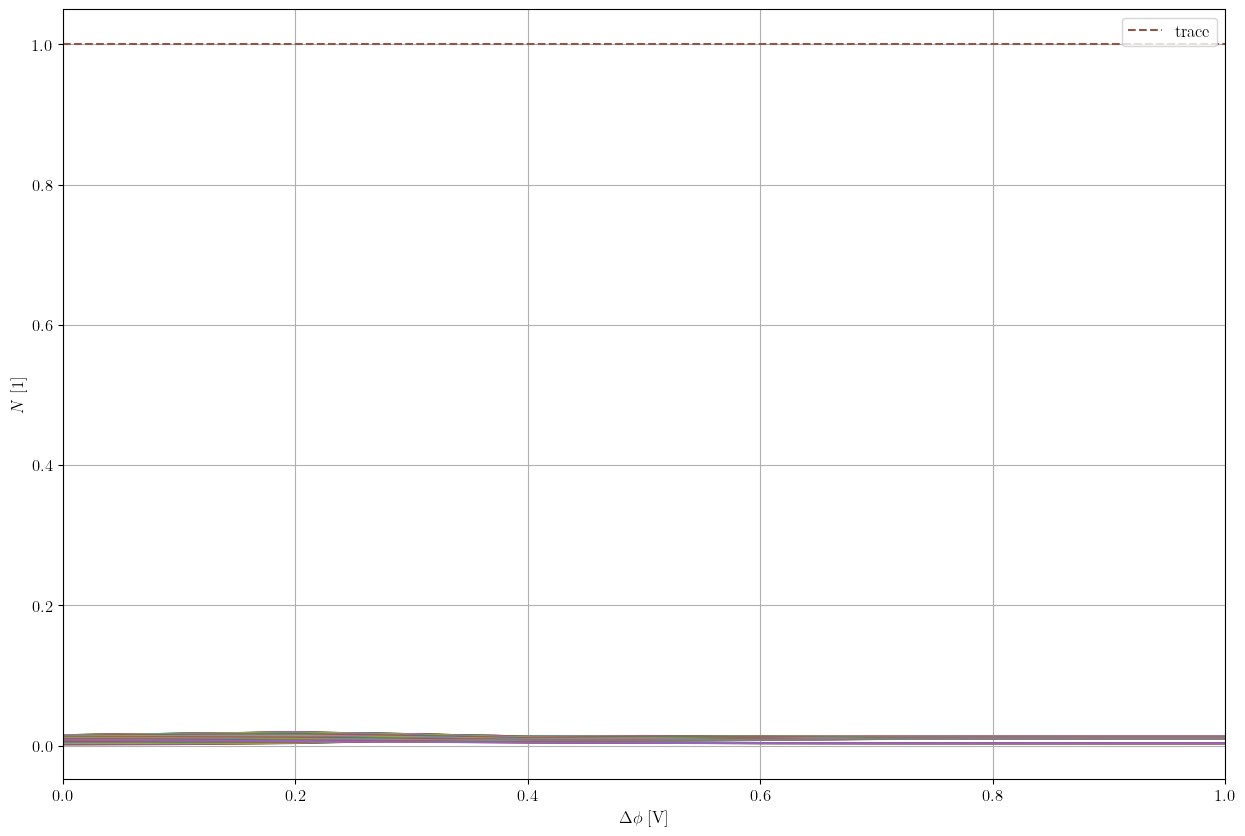

In [33]:
local_voltages = voltages[::10]

N_diag = 150
N = 75

solver = bmme.create_holstein_solver_via_diagonalization(epsilon, omega, lamda, N_diag, Gamma, 0.0, 0.0, T, T, include_digamma=True, chop=2*N)
#solver = create_holstein_solver_via_diagonalization(e_0, omega, lamda, 100, Gamma, 0.0, 0.0, T, T, include_digamma=True, chop=2*N)

print(solver.H_S.shape)

additionals = []

for i in range(N):
    for j in range(N):
        if i != j:
            additionals.append((i, j))
            
for i in range(N):
    for j in range(N):
        if i != j:
            additionals.append((N+i, N+j))

def my_func(i, voltage):
    solver.chemical_potential = numpy.array([-.5*voltage, .5*voltage])
    solver.construct_liouvillian()
    rho_ss = solver.find_steady_state(ignore_coherences=True, additional_coherences=additionals)
    #rho_ss = solver.find_steady_state(ignore_coherences=False)
    return (solver.get_currents(rho_ss), numpy.diag(solver.retransform_rho(rho_ss)))
    #return (solver.get_currents(rho_ss), numpy.diag(rho_ss))
    #return (solver.get_current(rho_ss), numpy.diag(partial_trace(rho_ss, 2)))

results = joblib.Parallel(n_jobs=2)(joblib.delayed(my_func)(i, voltage) for i, voltage in enumerate(tqdm(local_voltages)))

currents = numpy.zeros((len(local_voltages), 2))
populations = numpy.zeros((len(local_voltages), 2*N_diag))

for i, voltage in enumerate(local_voltages):
    currents[i] = results[i][0]
    populations[i] = results[i][1]

#for i, voltage in enumerate(tqdm(voltages)):

pyplot.figure(figsize=(15,10))
pyplot.plot(local_voltages, currents[:,0], label="$J_L$")
pyplot.plot(local_voltages, currents[:,1], label="$J_R$")
pyplot.plot(local_voltages, currents[:,0] + currents[:,1])

pyplot.grid()
pyplot.legend(loc=1)
pyplot.xlabel("$\\Delta\\phi$ [V]")
pyplot.ylabel("$J_K$ [mA]")
pyplot.ylim(-1.3e-3, 1.3e-3)
pyplot.xlim(0., 1.)
pyplot.show()

pyplot.figure(figsize=(15,10))
for i in range(N):
    pyplot.plot(local_voltages, populations[:,i] + populations[:,i + N_diag])

pyplot.plot(local_voltages, numpy.sum(populations, axis=1), ls="--", label="trace")    

pyplot.grid()
pyplot.legend(loc=1)
pyplot.xlabel("$\\Delta\\phi$ [V]")
pyplot.ylabel("$N$ [1]")
pyplot.xlim(0., 1.)
#pyplot.ylim(-.1, 1.1)
pyplot.show()

#numpy.save(f"data/holstein/currents_lamda{lamda}_{int(T/.026*300)}K_polaron", currents)
#numpy.save(f"data/holstein/populations_lamda{lamda}_{int(T/.026*300)}K_polaron", populations)

In [34]:
(populations[:,N] + populations[:,N_diag+N-1])

array([0.00817054, 0.00760691, 0.00638079, 0.0052864 , 0.00436103,
       0.00376261, 0.00341895, 0.00327059, 0.00323398, 0.00322788,
       0.00322696])

In [6]:
N_diag = 4

a_op = numpy.diag(numpy.sqrt(numpy.arange(1, N_diag)), k=1)
a_dag = numpy.transpose(a_op)

In [18]:
-0.5 * (a_dag - a_op) @ (a_dag - a_op)

array([[ 0.5       ,  0.        , -0.70710678,  0.        ],
       [ 0.        ,  1.5       ,  0.        , -1.22474487],
       [-0.70710678,  0.        ,  2.5       ,  0.        ],
       [ 0.        , -1.22474487,  0.        ,  1.5       ]])

In [21]:
a_dag @ a_op + .5 * numpy.identity(4)

array([[0.5, 0. , 0. , 0. ],
       [0. , 1.5, 0. , 0. ],
       [0. , 0. , 2.5, 0. ],
       [0. , 0. , 0. , 3.5]])